## Importing all modules in cell below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable, Iterable

## Load dummy 1-2-3 digit dataset

In [2]:
# data = np.loadtxt('../support/zipcombo.dat')
data_123 = np.loadtxt('../support/dtrain123.dat')

In [3]:
data_123.shape

(329, 257)

We now define functions for splitting the dataset into train/test and input/label.

In [4]:
def split_80_20(data: np.ndarray, seed: int) -> (np.ndarray, np.ndarray):
    """
    Splits 80% train 20% test

    :param data: sequence.
    :param seed: Random seed used to shuffle given data.
    :return: train_data, test_data: np.ndarray, np.ndarray
    """
    np.random.seed(seed)
    n = data.shape[0]
    shuffle = np.random.permutation(data)
    train_size = int(n*0.8)
    return shuffle[:train_size], shuffle[train_size:]

In [5]:
def split_X_y(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits the data into datapoints and labels, X_train matrix and y_train;
    :param data: np.ndarray
    :return: X_train, y_train: np.ndarray, np.ndarray
    """

    return data[:, 1:], data[:, 0]

In [6]:
# Test splitting functions
data_train_123, data_test_123 = split_80_20(data_123, seed=637)
X_train_123, y_train_123 = split_X_y(data_train_123)
X_test_123, y_test_123 = split_X_y(data_test_123)

assert X_train_123.shape[0] == y_train_123.size
assert X_test_123.shape[0] == y_test_123.size

print("Train data set size = %d" % X_train_123.shape[0])
print("Test data set size = %d" % X_test_123.shape[0])

# Testing data cleaning
y_train_123[100], X_train_123[100]

Train data set size = 263
Test data set size = 66


(2.0,
 array([-1.   , -1.   , -1.   , -1.   , -0.723,  0.203,  0.843,  1.   ,
         0.556, -0.415, -1.   , -1.   , -1.   , -1.   , -1.   , -1.   ,
        -1.   , -1.   , -1.   , -0.503,  0.885,  1.   ,  0.847,  0.878,
         1.   ,  0.966,  0.   , -1.   , -1.   , -1.   , -1.   , -1.   ,
        -1.   , -1.   , -0.499,  0.91 ,  0.752, -0.201, -0.916, -0.866,
        -0.312,  0.869,  0.952, -0.495, -1.   , -1.   , -1.   , -1.   ,
        -1.   , -0.809,  0.921,  0.29 , -0.973, -1.   , -1.   , -1.   ,
        -1.   , -0.194,  1.   ,  0.275, -1.   , -1.   , -1.   , -1.   ,
        -1.   , -0.906,  0.119, -0.853, -1.   , -1.   , -1.   , -1.   ,
        -1.   , -0.94 ,  1.   ,  0.736, -1.   , -1.   , -1.   , -1.   ,
        -1.   , -1.   , -1.   , -1.   , -1.   , -1.   , -1.   , -1.   ,
        -1.   , -0.767,  1.   ,  0.711, -1.   , -1.   , -1.   , -1.   ,
        -1.   , -1.   , -1.   , -1.   , -1.   , -1.   , -1.   , -1.   ,
        -1.   , -0.345,  1.   ,  0.142, -1.   , -1.   , -1

In [7]:
def display_digit(grayscale):
    plt.imshow(np.reshape(grayscale, (16, 16)), cmap='gray')

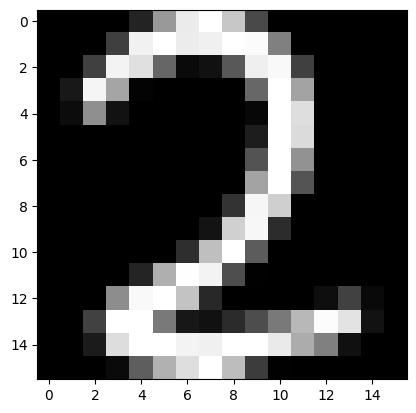

In [8]:
display_digit(X_train_123[100])

Let us now define the Kernel Perceptron algorithm and kernel functions to be used.

In [9]:
def polynomial_kernel(x_i: np.ndarray, x_t: np.ndarray, d: int):
    return np.inner(x_i, x_t) ** d

In [10]:
def gaussian_kernel(x_i: np.ndarray, x_j: np.ndarray, sigma=1):
    if x_i.shape[0] != x_j.shape[0]:
        raise Exception("Cannot apply kernel to vectors of different dimensions: x_i has shape {s1}, x_j has shape {s2}"
                        .format(s1=x_i.shape, s2=x_j.shape))
    diff = x_i - x_j
    return np.exp(-1 * np.inner(diff, diff) / (2 * sigma**2))

In [11]:
class KernelPerceptron:
    def __init__(self, kernel: Callable[[np.ndarray, np.ndarray], float]):
        self.kernel = kernel
        self.K = None
        self.alpha = None
        self.X_train = None


    def _get_kernel_matrix(self, X_train: np.ndarray) -> np.ndarray:
        K = np.zeros((X_train.shape[0], X_train.shape[0]))

        for i in range(0, X_train.shape[0]):
            for j in range(i, X_train.shape[0]):
                K[i, j] = K[j, i] = self.kernel(X_train[i], X_train[j])

        return K


    def fit(self, X_train: np.ndarray, y_train: np.ndarray, n_epochs: int) -> np.ndarray:
        """
        Prediction function that populates the alpha parameter, 1 data point at a time;
        :param X_train: training data points
        :param y_train: training corresponding labels
        :param n_epochs: number of times to pass through the data. Alpha contains the learning parameters that get inherited from one epoch to the other
        :return: y_preds: the predictions enhanced after N epochs

        """
        if y_train.ndim != 1:
            raise Exception('y_train must be a 1-dim np.ndarray. Given y_train with shape {s}'.format(s=y_train.shape))
        if X_train.shape[0] != y_train.size:
            raise Exception('X_train and y_train must contain equal number of samples. Given X_train with shape {s1} and y_train with shape {s2}'.format(s1=y_train.shape, s2=X_train.shape))

        y_preds = np.zeros(X_train.shape[0])
        self.X_train = X_train
        self.alpha = np.zeros(X_train.shape[0])

        # Compute kernel matrix which stays constant throughout the algorithm and all epochs
        self.K = self._get_kernel_matrix(X_train)

        for epoch in range(0, n_epochs):
            # First prediction is always 0, start from t = 1
            for t in range(0, X_train.shape[0]):
                y_pred = self._predict_single(t)
                y_preds[t] = y_pred
                if y_pred == y_train[t]:
                    self.alpha[t] = 0
                else:
                    self.alpha[t] += y_train[t]
        return y_preds


    def _predict_single(self, t: int):
        return np.sign(np.inner(self.K[t, :t], self.alpha[:t]))


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Prediction function to be used for out-of-sample test data point.
        Does not perform online learning (update step).
        :param X: test data points.
        :return: np.ndarray of predictions for each given test data point.
        """
        predictions = []
        for x_test in X:
            sum = 0
            for t in range(self.X_train.shape[0]):
                # Can improve by using kernel matrix
                sum += self.alpha[t] * self.kernel(self.X_train[t], x_test)
            predictions.append(np.sign(sum))
        return np.array(predictions)


kp = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
y_insample = kp.fit(X_train_12, y_train_12, n_epochs=1)

Let us test the Kernel Perceptron implementation on a dummy dataset of only digits 1 and 2.

array([ 1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,
       -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,
       -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1., -1.,  1., -1.,
        1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,
        1.,  1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
       -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1.,
        1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
        1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1

array([ 1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,
       -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,
        1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,
        1., -1.])

1.0

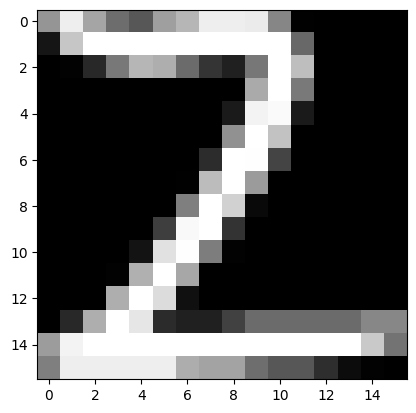

In [11]:
# Filter out digit 3 (leave only digit 1 and 2) from dtrain123.dat train and test dataset
indxs_digit_3 = np.where(y_train_123 == 3)
X_train_12 = np.delete(X_train_123, indxs_digit_3, axis=0)
y_train_12 = np.delete(y_train_123, indxs_digit_3)
y_train_12[y_train_12 == 1] = -1
y_train_12[y_train_12 == 2] = 1

indxs_digit_3 = np.where(y_test_123 == 3)
X_test_12 = np.delete(X_test_123, indxs_digit_3, axis=0)
y_test_12 = np.delete(y_test_123, indxs_digit_3)
y_test_12[y_test_12 == 1] = -1
y_test_12[y_test_12 == 2] = 1

assert X_train_12.shape[0] == y_train_12.size
assert X_test_12.shape[0] == y_test_12.size

display(y_train_12, y_test_12)

display_digit(X_train_12[5])
display(y_train_12[5])

In [ ]:
## Test the kernel matrix
kp_test = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
kernel_matrix = kp_test._get_kernel_matrix(X_train_12)
polynomial_kernel(X_train_12[0], X_train_12[0], d=3) == kernel_matrix[0][0]

In [ ]:
# Test fitting and in-sample predictions
kp = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
y_insample = kp.fit(X_train_12, y_train_12, n_epochs=1)
y_insample.size, y_train_12.size, y_insample

In [ ]:
# Test out-of-sample predictions
y_outsample = kp.predict(X_test_12) # all predictions of test sample in y_outsample
y_outsample

In [ ]:
def get_num_mistakes(actual: np.ndarray, predicted: np.ndarray) -> int:
    # or calculating by checking which alpha values are different than 0? alpha is 0 when the prediction matches
    diffs = actual - predicted
    n_mistakes = 0
    for diff in diffs:
        if diff != 0:
            n_mistakes += 1
    return n_mistakes

In [ ]:
print("in-sample = % " + str(100 * get_num_mistakes(actual=y_train_12, predicted=y_insample) / y_train_12.size))
print("out-of-sample = % " + str(100 * get_num_mistakes(actual=y_test_12, predicted=y_outsample) / y_test_12.size))


In [27]:
## Test the kernel matrix
kp_test = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
kernel_matrix = kp_test._get_kernel_matrix(X_train_12)
polynomial_kernel(X_train_12[0], X_train_12[0], d=3) == kernel_matrix[0][0]

True

In [28]:
# Test fitting and in-sample predictions
kp = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
y_insample = kp.fit(X_train_12, y_train_12, n_epochs=1)
y_insample.size, y_train_12.size, y_insample

(205,
 205,
 array([ 0.,  0.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,
         1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1.,
        -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,
        -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,
        -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
         1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1., -1.,
         1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
        -1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
        -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
         1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
         1., -1.,  1., -1., -1., -1.,  

In [29]:
# Test out-of-sample predictions
y_outsample = kp.predict(X_test_12) # all predictions of test sample in y_outsample
y_outsample

array([ 1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,
       -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,
        1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        1., -1.])

In [30]:
def get_num_mistakes(actual: np.ndarray, predicted: np.ndarray) -> int:
    # or calculating by checking which alpha values are different than 0? alpha is 0 when the prediction matches
    diffs = actual - predicted
    n_mistakes = 0
    for diff in diffs:
        if diff != 0:
            n_mistakes += 1
    return n_mistakes

In [31]:
print("in-sample = % " + str(100 * get_num_mistakes(actual=y_train_12, predicted=y_insample) / y_train_12.size))
print("out-of-sample = % " + str(100 * get_num_mistakes(actual=y_test_12, predicted=y_outsample) / y_test_12.size))


in-sample = % 18.048780487804876
out-of-sample = % 12.962962962962964


In [35]:
mist=0
for val in kp.alpha:
    if val!=0:
      mist+=1

In [36]:
# why is it different than get_mistakes? maybe is because alpha is 0?
mist

209

### Part 1

#### Basic results:
- for $d=1,...,7$
- perform 20 runs
- each run randomly split $zipcombo.dat$ in 80% train and 20% test

In [8]:
seeds = np.random.randint(0, 100, 20)

mse_train = []
std_train = []

mse_test = []
std_test = []

for d in range(1, 7):
    for run in range(20):
        # different seed for each run
        train, test = split_80_20(lines, seeds[run])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
